##  <font color=MediumSlateBlue>Importing Libraries</font> ##

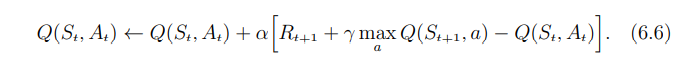

In [2]:
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style

##  <font color=MediumSlateBlue>Directions</font> ##

In [3]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

##  <font color=MediumSlateBlue>Environment</font> ##

In [4]:
class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      # P[s][a] = (prob, next_state, reward, is_done)
      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,45,63,64]
      no_down = lambda s: s in [23,24,25,44]
      no_left = lambda s: s in [44,36,55]
      no_right = lambda s: s in [32,42,52]

      #Barriers in the path
      pit = lambda s: s in [13,62,41]
      wall = lambda s: s in [43,33,53,34,35,54]

      #Rewards of each state
      reward = 1.0 if is_done(s) else 0.0
      reward = -10.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -3.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -3.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -3.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -3.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[np.random.randint(0,100)]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)
  def returnToStart(self):
    self.s = 44
  def randomStart(self):
    self.s = np.random.randint(0, 100)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,62,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,62,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,35,54]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()



In [5]:
    env =  GridworldEnv()
    env.reset()
    env._render()

       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    웃   .    .  
  .    .    .    █    █    █    .    .    .    .  
  .         .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  


In [11]:
    env =  GridworldEnv()
    env.reset()
    env._render()
    # Initialize q table 
    nS = 100 
    nA = 4
    gamma = 0.9 
    alpha = 0.1
    state = 44
    qTable = np.zeros((100,4))
    # qTable = np.random.rand(100, 4)

    for i in range(1000):
      iter = 0 
      done = False
      totalReward = 0 
      env.s = np.random.randint(10, 100)
      initialState = state
      rewards = []
      moves = []
      while not done:
        iter += 1
        if np.random.uniform(0, 1) <0.5 : 
          action = env.action_space.sample()
        else : 
          action = np.argmax(qTable[state, :])
        
        statePrime, reward, done, info = env.step(action)
        if(statePrime in [13,62,41]) :
          env.s = initialState 
          print(reward)
        totalReward += reward
        rewards.append(reward)
        moves.append(statePrime)
        Q = qTable[state, action]
        maxQ = np.max(qTable[statePrime])
        QPrime = (1 - alpha) * Q + alpha * (reward + gamma * maxQ)
        qTable[state, action] = QPrime
        state = statePrime 
        if iter > 2000 :
          break
      print('total reward is ', totalReward)
      print('moves are', moves)
      print('rewards are ', rewards)
      env.reset()
      env.randomStart()
      env._render()
    print(done)

Streaming output truncated to the last 5000 lines.
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
0.0
total reward is  1.0
moves are [68, 78, 79, 78, 88, 89, 89, 79, 69, 68, 58, 48, 47, 37, 36, 37, 47, 37, 47, 48, 47, 57, 67, 57, 47, 37, 36, 37, 36, 46, 36, 26, 25, 15, 16, 17, 7, 6, 5, 4, 4, 5, 15, 25, 15, 5, 4, 3, 13, 0]
rewards are  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    █    .    .    웃   .  
 

In [8]:
print(qTable)

[[ 3.24830734e-01 -1.44793438e-01 -1.42317744e+00 -7.06525734e-02]
 [ 0.00000000e+00  1.11522905e-01  3.32345590e-04 -2.08424809e-02]
 [ 5.64358617e-02  4.02944112e-01  5.70293723e-02  1.92607015e-03]
 [ 2.76001479e-02  3.05340461e-01  8.33681898e-01  5.08485459e-02]
 [ 3.95093641e-01  4.73040204e-01  9.56031115e-01  3.88037433e-01]
 [ 4.66219870e-01  3.10563461e-01  8.31046439e-01  5.65368880e-01]
 [ 9.20699189e-02  1.09420843e-02  6.79087241e-01  2.90632949e-01]
 [ 1.82147777e-02  4.94210696e-04  6.91379822e-02  2.41069949e-01]
 [ 1.90601400e-04  5.81829657e-03  1.59936902e-01  2.62250037e-02]
 [ 0.00000000e+00  1.45232245e-07  5.85126286e-02  4.97082686e-05]
 [-6.39660048e-02  5.24685832e-02  2.05650324e-02  1.86725950e-04]
 [ 9.95582175e-03  1.85850419e-02  2.77028244e-01  3.45391201e-03]
 [ 6.38934506e-02  1.07254751e-01  3.76499562e-01  2.13355189e-02]
 [ 1.21091230e+00  1.12409003e+00  1.04026235e+00  1.01436320e+00]
 [ 8.52919853e-01  8.40036056e-01  8.16832779e-01  1.02259157e

In [9]:
print(qTable)

[[ 3.24830734e-01 -1.44793438e-01 -1.42317744e+00 -7.06525734e-02]
 [ 0.00000000e+00  1.11522905e-01  3.32345590e-04 -2.08424809e-02]
 [ 5.64358617e-02  4.02944112e-01  5.70293723e-02  1.92607015e-03]
 [ 2.76001479e-02  3.05340461e-01  8.33681898e-01  5.08485459e-02]
 [ 3.95093641e-01  4.73040204e-01  9.56031115e-01  3.88037433e-01]
 [ 4.66219870e-01  3.10563461e-01  8.31046439e-01  5.65368880e-01]
 [ 9.20699189e-02  1.09420843e-02  6.79087241e-01  2.90632949e-01]
 [ 1.82147777e-02  4.94210696e-04  6.91379822e-02  2.41069949e-01]
 [ 1.90601400e-04  5.81829657e-03  1.59936902e-01  2.62250037e-02]
 [ 0.00000000e+00  1.45232245e-07  5.85126286e-02  4.97082686e-05]
 [-6.39660048e-02  5.24685832e-02  2.05650324e-02  1.86725950e-04]
 [ 9.95582175e-03  1.85850419e-02  2.77028244e-01  3.45391201e-03]
 [ 6.38934506e-02  1.07254751e-01  3.76499562e-01  2.13355189e-02]
 [ 1.21091230e+00  1.12409003e+00  1.04026235e+00  1.01436320e+00]
 [ 8.52919853e-01  8.40036056e-01  8.16832779e-01  1.02259157e

In [10]:
env =  GridworldEnv()
env.reset()
env._render()
iter = 0 
done = False
totalReward = 0 
env.s = np.random.randint(10, 100)
initialState = state
rewards = []
moves = []
while not done:
  iter += 1
  action = np.argmax(qTable[state, :])
  statePrime, reward, done, info = env.step(action)
  if(statePrime in [13,62,41]) :
    env.s = initialState 
    print(reward)
  totalReward += reward
  rewards.append(reward)
  moves.append(statePrime)
  env._render()
print('total reward is ', totalReward)
print('moves are', moves)
print('rewards are ', rewards)



##  <font color=MediumSlateBlue>How to use the above class?</font> ##

In [ ]:
env =  GridworldEnv()
env.reset()
env._render()

for _ in range(2):
    movements = []
    totalReward = 0 
    Rewards = []
    done = False 
    iter = 0 
    # Take a random action
    while not done : 
      movements.append(state)
      action = env.action_space.sample()
      state, reward, done, info = env.step(action)
      totalReward += reward
      Rewards.append(totalReward)
      if len(movements) >200 :
        done = True
      if state in  [13,62,41]:
        env.returnToStart()
        env._render()
        done = True
      print(info)
      print('action:',action)
      env._render()
      print(movements)
      print(totalReward)
      iter += 1 
env.close()

##  <font color=MediumSlateBlue>In google colab you may need to install the below library.</font> ##

In [ ]:
!pip install colorama